In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
import re
import os
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")
from domainbed.codeplot import plot
plot.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/nlp")

In [2]:
plot.dict_key_to_label.update(
    {
        "pos1": "Review positivity",
        "posimdb": "lvwerra/distilbert-imdb",
        "pos": "distilbert-base-uncased-finetuned-sst-2-english",
        "toxic": "martin-ha/toxic-comment-model",
        "quality2": "valurank/distilbert-quality",
        # "hfl": "OpenAssistant/reward-model-deberta-v3-large-v2",
        "hfb": r"$R_1$",
        "hfd": r"$R_2$",
        "hfbv": r"$R_1$",
        # "hfg": "sugam11/gpt2-rlhf-reward",
        "cogd": r"$R_2$",
        "tristan": r"$R_1$",
    }
)
# plot.plt.rcParams["figure.figsize"] = (7, 7)
# plot.SIZE_AXIS = "small"
# plot.SIZE = "small"
plot.plt.rcParams["figure.figsize"] = (6, 6)
SIZE="large"
SIZE_AXIS="xx-large"


colormaps = [
    "Reds", "Blues", "Greens", "Oranges", "Greys", "Purples", "Reds", "Blues", "Greens", "Oranges",
    "Greys", "Purples",
"Yellows",
"Light_Yellows",
"Dark_Blues",
"Blues_Greys",
"Dark_Greys",
] * 2
do_save = True

label_x = "R_1"
label_y = "R_2"
label_xy = "R_1+R_2"
clean_kwargs = {
    "labels":
        [
            r"RL: ${label_x}$".format(label_x=label_x
                                     ),
            r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
            r"RL: ${label_y}$".format(label_y=label_y),
            r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
            r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
            # r"WA: $$ $\to$ ${label_y}$, $0\leq\lambda\leq1$".format(label_x=label_x, label_y=label_y)
            r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)
        ],
    "loc": "no",
    "colormaps": ["Blues", "Blues", "Reds", "Reds", "Purples", "Greens"],
    "linestyles": ["dotted", "dashed", "dotted", "dashed", "dotted", "solid"],
    "order": "savgol_3_1_quadratic",
    "list_indexes": [0, 2, 4, 5]
}
arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropsinv = dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', linewidth=1, shrinkA=0)

keys_y = ["norm|tristan", "norm|cogd", "norm|cogfaithful"]

clean_kwargs_scatter = {
    "key_x": "lambda",
    "loc": "lower left",
    "colormaps": ["Blues", "Reds", "Greens", "Purples", "Yellows", "Greys"],
    "linestyles": ['dotted', 'dotted', "solid", "solid", "solid", "solid"],
    "order": "savgol_3_1_quadratic",
    # keycolor="abs|lambda-0.5",
    "order": "3",
    "legendtitle": f"Rewards for {clean_kwargs['labels'][5]}:",
    "title": None,
}

def plot_scatter_nlp(l, keys_y, **kwargs):
    for key in clean_kwargs_scatter.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs_scatter[key]
    fig_dr = plot.plot_basic_scatter(
        l,
        keys_y=keys_y,
        **clean_kwargs_scatter,
    )
    return fig_dr


def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise ValueError()


def plot_key_nlp(list_l, key_x, key_y, *args, do_annotate=True, dict_annotation_to_loc={}, **kwargs):
    for key in clean_kwargs.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs[key]
    fig_dr = plot.plot_key(list_l, key_x=key_x, key_y=key_y, *args, **kwargs)
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            "pre-trained init",
            xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
            xytext=dict_annotation_to_loc.get("pt"),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"${label_x}$".format(label_x=label_x) + " rewarded",
            xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
            xytext=dict_annotation_to_loc.get("0"),
            ha='right',
            va="bottom",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            r"${label_y}$".format(label_y=label_y) + " rewarded",
            xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
            xytext=dict_annotation_to_loc.get("1"),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )

        arrowpropsinv.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"$\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy) + " rewarded",
            xy=(list_l[4][-1][key_x], list_l[4][-1][key_y]),
            xytext=dict_annotation_to_loc.get("01"),
            ha='left',
            va="bottom",
            size=plot.SIZE,
            arrowprops=arrowpropsinv
        )
        if dict_annotation_to_loc.get("lambda") == "right":
            arrowprops.update({"relpos": (0.5, 0)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(get_at_coeff(list_l[5])[key_x], get_at_coeff(list_l[5])[key_y]),
                ha='right',
                va="bottom",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        else:
            arrowprops.update({"relpos": (0.5, 1)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(
                    get_at_coeff(list_l[5])[key_x],
                    get_at_coeff(list_l[5])[key_y]
                ),
                xytext=dict_annotation_to_loc.get("lambda"),
                ha='left',
                va="top",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        del arrowprops["relpos"]
    return fig_dr

In [3]:
class EmptyModule:
    l = None
    label = ""

In [4]:
# llama stack

In [6]:
os.listdir("/data/rame/logs_experiments_notebook/nlp/llamastacku/")

['infstacku_warmdvb311rmeld391_0415.py',
 'infstacku_wainitrmeld391_0415.py',
 'infstacku_rmdvbrmeld_0418_1000.py',
 'infstacku_warmdvb351rmeld361_0415.py',
 'infstacku_rmdvbrmeld_0414.py',
 'infstacku_rmdvb_0414.py',
 '__pycache__',
 'infstacku_warmdvb311rmeld391_0418_1000.py',
 'llama_experiments_stacku.md',
 'infstacku_wainitrmdvb311_0415.py',
 'infstacku_warmdvbrmeld_0414.py',
 'infstacku_rmeld_0414.py']

In [6]:
from llamastacku import infstacku_rmeld_0414, infstacku_rmdvb_0414, infstacku_rmdvbrmeld_0414, infstacku_rmdvbrmeld_0418_1000, infstacku_warmdvbrmeld_0414, infstacku_warmdvb311rmeld391_0415, infstacku_warmdvb351rmeld361_0415, infstacku_wainitrmeld391_0415, infstacku_wainitrmdvb311_0415, infstacku_warmdvb311rmeld391_0418_1000

modules_stacku = [
    infstacku_rmdvb_0414, infstacku_wainitrmdvb311_0415, infstacku_rmeld_0414,
    infstacku_wainitrmeld391_0415, infstacku_rmdvbrmeld_0414,
    infstacku_warmdvb311rmeld391_0415
]

modules_stacku_1000 = [
    infstacku_rmdvb_0414, infstacku_wainitrmdvb311_0415, infstacku_rmeld_0414,
    infstacku_wainitrmeld391_0415, infstacku_rmdvbrmeld_0418_1000,
    infstacku_warmdvb311rmeld391_0418_1000
]


In [7]:
for modules in [modules_stacku, modules_stacku_1000]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[0:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["gpt2"] = module.d[key][0]["LABEL_0"]
                new_d["hfb"] = module.d[key][1]["REWARD"]
                new_d["hfd"] = module.d[key][2]["REWARD"]
                new_d["hfl"] = module.d[key][3]["LABEL_0"]
                module.l.append(new_d)

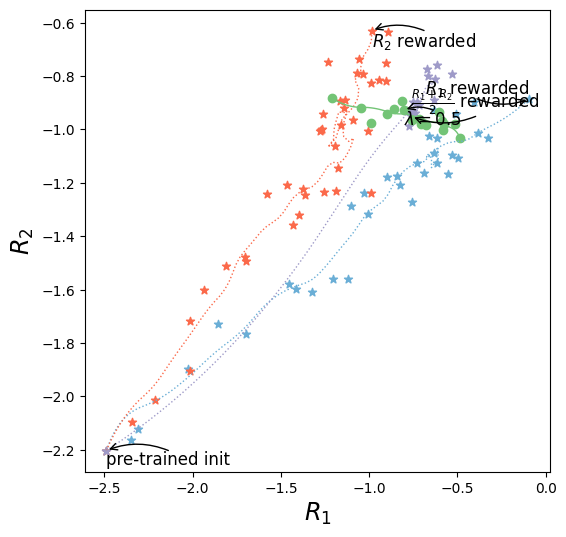

In [9]:
# fig_dr = plot_key_nlp(
#     [module.l if module is not None else None for module in modules_stacku_1000],
#     key_x="hfb",
#     key_y="hfd",
#     order="savgol_7_1_quadratic",
#     # order="3",
#     dict_annotation_to_loc={
#         # "pt": None,
#         # "0": (-0.05, -1.3),
#         # "1": (-1.56, -0.5),
#         # "lambda": (-0.35, -0.6)
#     },
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_stacku1000_hfbtohfd.pdf", do_save=do_save)

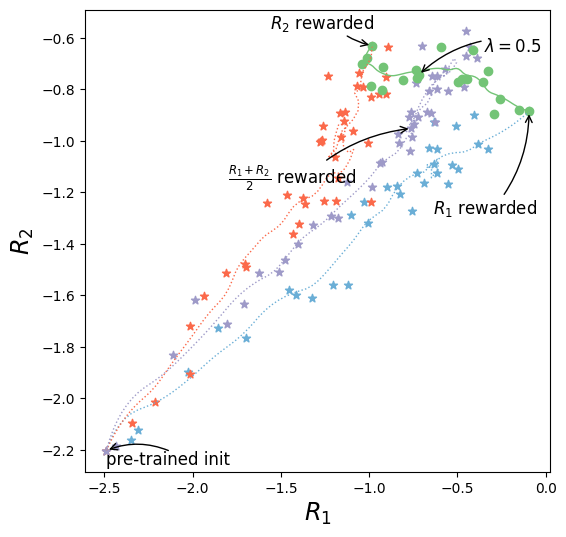

In [8]:
fig_dr = plot_key_nlp(
    [module.l if module is not None else None for module in modules_stacku],
    key_x="hfb",
    key_y="hfd",
    order="savgol_7_1_quadratic",
    # order="3",
    dict_annotation_to_loc={
        "pt": None,
        "0": (-0.05, -1.3),
        "1": (-1.56, -0.5),
        "01": (-1.8, -1.2),        
        "lambda": (-0.35, -0.6)
    },
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_stacku_hfbtohfd.pdf", do_save=do_save)

In [11]:
# LLama assistant

In [5]:
os.listdir("/data/rame/logs_experiments_notebook/nlp/llamaassistantkl2/")

['infassistant_warmeldrmdvbv_step191_0418.py',
 'logs_assistant_d_steps_0412.py',
 'logs_assistant_b_steps_0412.py',
 'infassistant_rmdvbv_steps_0418.py',
 'infassistant_warmeldrmdvbv_step201_0418.py',
 'infassistant_warmeld201rmdvbv361_0418.py',
 'logs_assistant_bd_wa_0412.py',
 'infassistant_rmdvlv_steps_0418.py',
 '__pycache__',
 'infassistant_warmeldrmdvbv_step141_0418.py',
 'infassistant_multirmeldrmdvbv_steps_0418.py',
 'infassistant_rmeld_steps_0418.py',
 'experiments_assistant_kl2.md',
 'infassistant_dvxr_steps_0418.py',
 'infassistant_warmeld191rmdvbv361_0418.py',
 'infassistant_warmeldrmdvlv_step201_0418.py']

In [7]:
from llamaassistantkl2 import logs_assistant_d_steps_0412, logs_assistant_b_steps_0412, logs_assistant_bd_wa_0412, infassistant_rmdvlv_steps_0418, infassistant_rmdvbv_steps_0418, infassistant_rmeld_steps_0418, infassistant_warmeldrmdvbv_step141_0418, infassistant_warmeldrmdvbv_step191_0418, infassistant_warmeldrmdvbv_step201_0418, infassistant_warmeldrmdvlv_step201_0418, infassistant_warmeld191rmdvbv361_0418, infassistant_warmeld201rmdvbv361_0418, infassistant_multirmeldrmdvbv_steps_0418, infassistant_dvxr_steps_0418
from llamaassistantkl2s1000 import infassistant_warmeldrmdvbv_step141_0418_1000, infassistant_warmeldrmdvbv_step191_0418_1000

In [8]:
modules_assistant_bv = [
    infassistant_rmdvbv_steps_0418,
    EmptyModule(), infassistant_rmeld_steps_0418,
    EmptyModule(), infassistant_multirmeldrmdvbv_steps_0418,
    infassistant_warmeld201rmdvbv361_0418
]

modules_assistant_bv_tmp = [
    infassistant_rmdvbv_steps_0418, infassistant_warmeld191rmdvbv361_0418,
    infassistant_rmeld_steps_0418, infassistant_warmeldrmdvbv_step141_0418,
    infassistant_warmeldrmdvbv_step191_0418, infassistant_warmeldrmdvbv_step201_0418,
    infassistant_warmeld201rmdvbv361_0418
]

modules_assistant_spider = [
    infassistant_rmeld_steps_0418,
    infassistant_rmdvbv_steps_0418,
    infassistant_rmdvlv_steps_0418,
    logs_assistant_b_steps_0412,
    infassistant_dvxr_steps_0418,
    EmptyModule(),
]
modules_assistant_kl2_1000 = [
    infassistant_rmdvbv_steps_0418,
    EmptyModule(),
    infassistant_rmeld_steps_0418,
    EmptyModule(),
    infassistant_warmeldrmdvbv_step141_0418_1000,
    infassistant_warmeldrmdvbv_step191_0418_1000
]
for modules in [modules_assistant_spider, modules_assistant_bv, modules_assistant_bv_tmp, modules_assistant_kl2_1000]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            new_d = {"lambda": key}
            new_d["hfl"] = module.d[key][0]["LABEL_0"]
            new_d["hfb"] = module.d[key][1]["REWARD"]
            new_d["hfd"] = module.d[key][2]["REWARD"]
            if "LABEL_0" in module.d[key][3]:
                new_d["hfbv"] = module.d[key][3]["LABEL_0"]
            else:
                new_d["hfbv"] = 0
            module.l.append(new_d)

# infassistant_rmdvbv_steps_0418.l = [line for line in infassistant_rmdvbv_steps_0418.l if line["lambda"] < 1 + 0.7416974169741697]
# infassistant_rmeld_steps_0418.l = [
#     line for line in infassistant_rmeld_steps_0418.l if line["lambda"] < 1 + 0.7047970479704797
# ]


infassistant_warmeld201rmdvbv361_0418.l = infassistant_warmeld191rmdvbv361_0418.l[:11] + infassistant_warmeld201rmdvbv361_0418.l[11:]

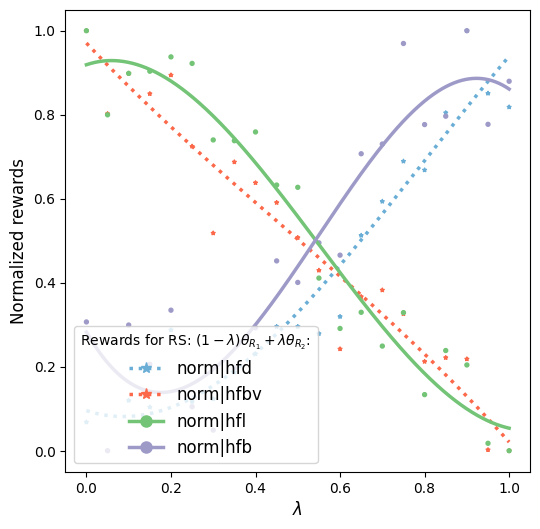

In [12]:
fig_dr = plot_scatter_nlp(
    infassistant_warmeld201rmdvbv361_0418.l,
    keys_y=[
        "norm|hfd",
        "norm|hfbv",
        "norm|hfl",
        "norm|hfb",
    ],
)

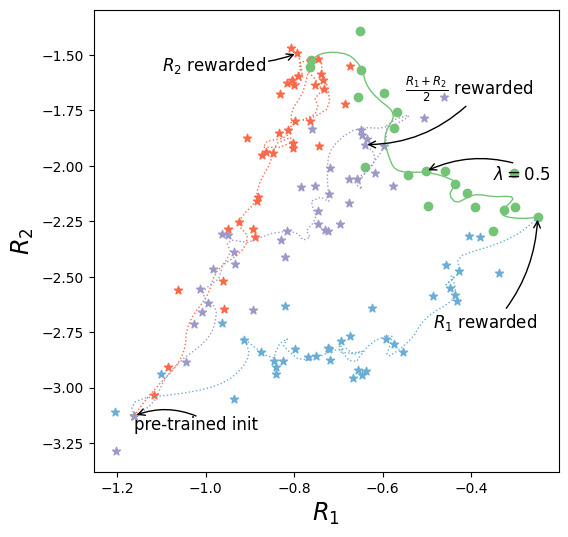

In [8]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_bv],
    # labels=[module.label for module in modules_assistant_bv],
    key_x="hfbv",
    key_y="hfd",
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    do_annotate=True,
    dict_annotation_to_loc={
        # "pt": (1.15, -1.8),
        "0": (-0.25, -2.75),
        "1": (-1.1, -1.5),
        "lambda": (-0.35, -2),
        "01": (-0.55, -1.72),
    },    
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hfbvtohfd.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_assistant_bv_tmp],
#     labels=[module.label for module in modules_assistant_bv_tmp],
#     colors=["red", "pink", "blue", "yellow", "purple", "green", "grey"],
#     colormaps=None,
#     key_x="hfbv",
#     key_y="hfd",
#     list_indexes=None,
#     loc="lower right",
#     # order="3",
#     # keysize="lambda",
#     fontsize="x-small",
#     do_annotate=False,
#     # connect_endpoints=True
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_kl2.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_assistant_kl2_1000],
#     labels=[module.label for module in modules_assistant_kl2_1000],
#     # colors=["red", "pink", "blue", "yellow", "purple", "green"],
#     key_x="hfbv",
#     key_y="hfd",
#     list_indexes=[0, 2, 4, 5],
#     loc="lower right",
#     order="connect",
#     # keysize="lambda",
#     fontsize="x-small",
#     do_annotate=False,
#     # connect_endpoints=True
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_kl2.pdf", do_save=do_save)

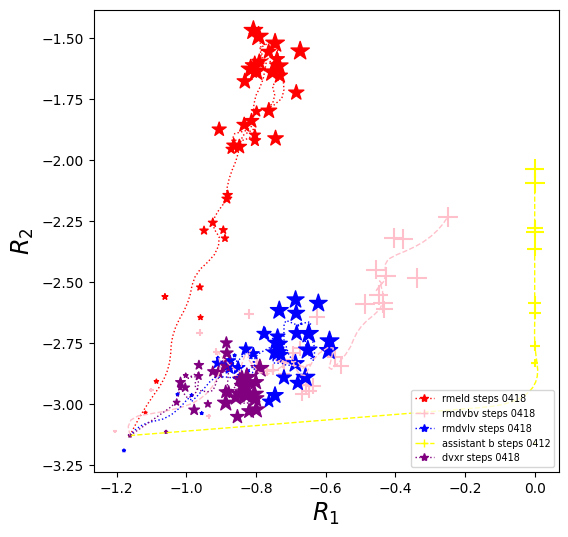

In [12]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_spider],
    labels=[module.label for module in modules_assistant_spider],
    colors=["red", "pink", "blue", "yellow", "purple", "green"],
    list_indexes=None,
    key_x="hfbv",
    key_y="hfd",
    loc="lower right",
    # order="connect",
    keysize="lambda",
    fontsize="x-small",
    do_annotate=False,
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/spider_assistant.pdf", do_save=do_save)

In [ ]:
# Llama assistant with kL

In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/nlp/llamaassistant/")

In [19]:
from llamaassistant import logs_assistant_d_kl_steps, logs_assistant_d_kl_steps, logs_assistant_d_steps, logs_assistant_bd_wa, logs_assistant_wainittodkl, logs_assistant_bkl_steps_0406, logs_assistant_multikl_steps_0406, logs_assistant_wainittobkl_0406, logs_assistant_wabkltodkl_0410, logs_assistantsteps_hfb_kl005_fmulti_normallr, logs_assistantsteps_hfb_kl005_fmulti, logs_assistantsteps_hfd_kl005_fmulti_normallr, logs_assistantsteps_hfd_kl005_fmulti, logs_assistant_bkl_steps_jz, infassistant_rmdvbv_steps_0416, infassistant_bkl_frommultiklv3_steps_0406, infassistant_warmeld181rmdvlv231_0416, infassistant_warmeld221rmdvlv141_0416, infassistant_warmeld221rmdvbv161_0416, infassistant_warmeld81rmdvlv91_0416, infassistant_warmeld81rmdvbv161_0416,
from llamaassistant import logs_assistant_bkl_steps_0406, logs_assistant_d_kl_steps, logs_assistant_wainittodkl, logs_assistant_multikl_steps_0406, logs_assistant_bkl_steps_jz, logs_assistant_rmdvlv_steps_0416, logs_assistant_dkl_steps_0416

SyntaxError: trailing comma not allowed without surrounding parentheses (266817938.py, line 1)

In [20]:
for key in logs_assistant_d_kl_steps.d.keys():
    assert key in logs_assistant_dkl_steps_0416.d
    logs_assistant_d_kl_steps.d[key] = [
        logs_assistant_d_kl_steps.d[key][0], logs_assistant_d_kl_steps.d[key][1],
        logs_assistant_d_kl_steps.d[key][2], logs_assistant_dkl_steps_0416.d[key][1],
        logs_assistant_dkl_steps_0416.d[key][0]
    ]
modules_xx = [logs_assistant_d_kl_steps]
modules_multi = [logs_assistant_multikl_steps_0406, infassistant_bkl_frommultiklv3_steps_0406]





modules_lvd = [
    logs_assistant_rmdvlv_steps_0416,
    EmptyModule(),
    logs_assistant_d_kl_steps,
    EmptyModule(),
    infassistant_warmeld81rmdvlv91_0416, infassistant_warmeld221rmdvlv141_0416]
# infassistant_warmeld181rmdvlv231_0416

modules_bvd = [
    infassistant_rmdvbv_steps_0416,
    EmptyModule(),
    logs_assistant_d_kl_steps,
    EmptyModule(),
    infassistant_warmeld221rmdvbv161_0416,
    infassistant_warmeld81rmdvbv161_0416
]

modules_bd = [
    # logs_assistant_bkl_steps_0406,
    logs_assistant_b_steps,
        EmptyModule(),
    # logs_assistant_d_kl_steps,
    logs_assistant_d_steps,
        EmptyModule(),
    logs_assistant_multikl_steps_0406,
    EmptyModule()
]
for modules in [modules_multi, modules_xx, modules_bd, modules_bvd, modules_lvd]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["hfl"] = module.d[key][0]["LABEL_0"]
                new_d["hfb"] = module.d[key][1]["REWARD"]
                new_d["hfd"] = module.d[key][2]["REWARD"]
                if "LABEL_0" in module.d[key][3]:
                    new_d["hfbv"] = module.d[key][3]["LABEL_0"]
                else:
                    new_d["hfbv"] = 0
                if len(module.d[key]) > 4 and "LABEL_0" in module.d[key][4]:
                    new_d["dvxr"] = module.d[key][4]["LABEL_0"]
                module.l.append(new_d)

# logs_assistant_d_kl_steps.l = [line for line in logs_assistant_d_kl_steps.l if line["lambda"] < 0.2834890965732087]
# logs_assistant_rmdvlv_steps_0416.l = [line for line in logs_assistant_rmdvlv_steps_0416.l if line["lambda"] < 1 + 0.578544061302682]
# infassistant_rmdvbv_steps_0416.l = [line for line in infassistant_rmdvbv_steps_0416.l if line["lambda"] < 0.5166163141993958]


NameError: name 'logs_assistant_d_kl_steps' is not defined

In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_bvd],
    key_x="hfbv",
    key_y="hfd",
    loc="upper left",
    # order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_bvtod.pdf", do_save=do_save)

In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_lvd],
    key_x="hfl",
    key_y="hfb",
    loc="upper left",
    # order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_lvtod.pdf", do_save=do_save)

In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_bd],
    labels=[module.label for module in modules_bd],
    key_x="hfb",
    key_y="hfd",
    loc="upper left",
    order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_btod.pdf", do_save=do_save)

In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_xx],
    labels=[module.label for module in modules_xx],
    key_x="dvxr",
    key_y="hfbv",
    loc="upper left",
    do_annotate=False
)

In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_multi],
    labels=[module.label for module in modules_multi],
    colors=["purple", "blue"],
    key_x="hfb",
    key_y="hfd",
    # loc="upper left",
    do_annotate=False
)

# Llama Summary news

In [12]:
from llamasummarynews import  logs_summarynew_alpaca_tristan, logs_summarynew_alpaca_cog, logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_tristan_cog, logs_summarynew_multi, logs_snew_multi_cog, logs_snew_multi_tristan

In [13]:
modules_summary_news = [
    logs_summarynew_tristan_steps, logs_summarynew_alpaca_tristan, logs_summarynew_cog_steps,
    logs_summarynew_alpaca_cog, logs_summarynew_multi, logs_summarynew_tristan_cog,
]

modules_summary_new_all = [logs_snew_multi_cog, logs_snew_multi_tristan]


In [14]:
for modules in [modules_summary_news]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label")or True:
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[2:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["tristan"] = module.d[key][0]["LABEL_0"]
                new_d["cogd"] = module.d[key][1]["FAITHFUL"] - module.d[key][1]["HALLUCINATED"]
                new_d["cogfaithful"] = module.d[key][1]["FAITHFUL"]
                module.l.append(new_d)
logs_summarynew_tristan_steps.l = [line for line in logs_summarynew_tristan_steps.l if line["lambda"] <= 0.6273291925465838]

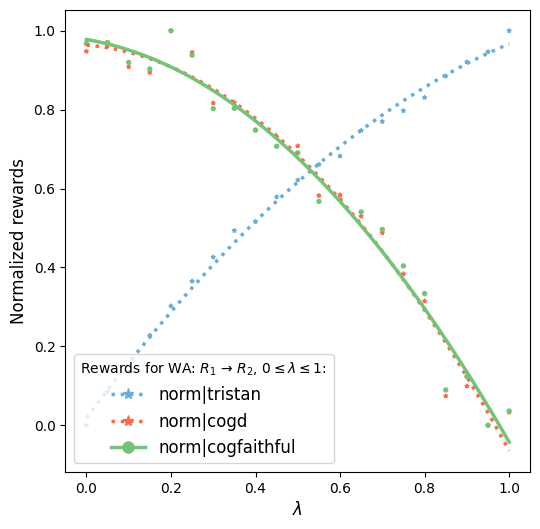

In [31]:
# fig_dr = plot_scatter_nlp(
#     modules_summary_news[5].l,
#     keys_y=["norm|tristan", "norm|cogd", "norm|cogfaithful"],
# )

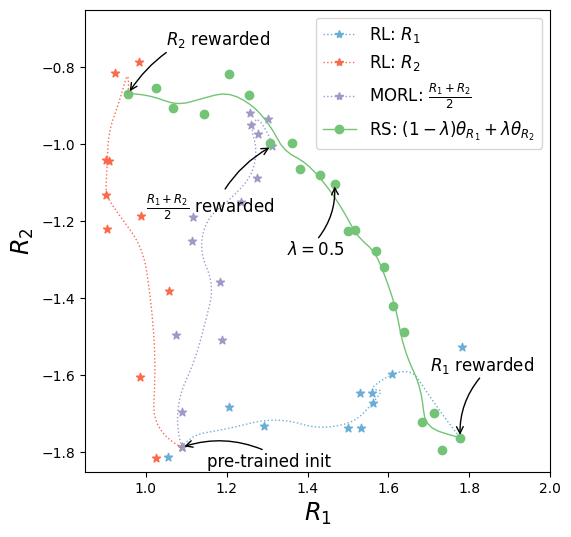

In [27]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_summary_news],
    key_x="tristan",
    key_y="cogd",
    loc="upper right",
    # legendtitle="Strategies:",
    dict_annotation_to_loc={
        "pt": (1.15, -1.8),
        "0": (1.96, -1.6),
        "1": (1.05, -0.7),
        "lambda": (1.35, -1.25),
        "01": (1.0, -1.2),
    },
    _dict_key_to_limit={
        "cogd": [-1.85, -0.65],
        "tristan": [0.85, 2.]
    }
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_main.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_summary_news],
#     key_x="tristan",
#     key_y="cogd",
#     # loc="upper right",
#     # fontsize="medium",
#     dict_annotation_to_loc={
#         "pt": (1.15, -1.8),
#         "0": (1.7, -1.83),
#         "1": (1., -0.78),
#         "01": (1.35, -0.95),
#     },
# )
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd.pdf", do_save=do_save)

# Llama Summary

In [22]:
from llamasummary import logs_tristan_cog_step20_v0, logs_tristan_cog_step40_kl005, logs_tristan_cog_step40, logs_tristan_cog_step30, logs_tristan_cog_step40_v0, logs_cogsoups_step40, logs_alpaca_cogsoups_step40, logs_alpaca_cog, logs_alpaca_cog_kl005, logs_tristan_cog_stepend, logs_alpaca_tristan_kl005, logs_multi_step40_200_kl005, logs_multitask_tristan_190_200, logs_multitask_cog_190_200, logs_cog_steps_200, logs_tristan_steps_200

In [23]:
modules_summary = [
    logs_tristan_steps_200,
    logs_alpaca_tristan_kl005,
    logs_cog_steps_200,
    logs_alpaca_cog_kl005,
    logs_multi_step40_200_kl005,
    logs_tristan_cog_step40_kl005]
modules_summary_all = [
    logs_multitask_tristan_190_200,
    logs_multitask_cog_190_200
]


In [24]:
for modules in [modules_summary]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["tristan"] = module.d[key][0]["LABEL_0"]
                new_d["cogd"] = module.d[key][1]["FAITHFUL"] - module.d[key][1]["HALLUCINATED"]
                new_d["cogfaithful"] = module.d[key][1]["FAITHFUL"]
                module.l.append(new_d)

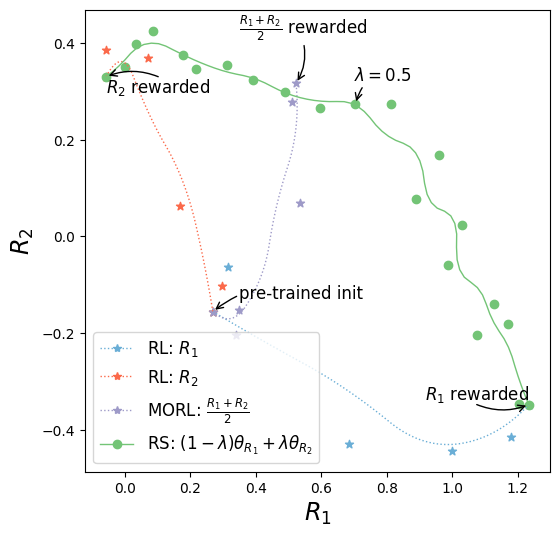

In [28]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_summary],
    key_x="tristan",
    key_y="cogd",
    loc="lower left",
    dict_annotation_to_loc={
        "pt": (0.35, -0.1),
        # "0": (1.96, -1.6),
        # "1": (1.05, -0.7),
        "lambda": (0.7, 0.35),
        "01": (0.35, 0.4),
    },
    # _dict_key_to_limit={
    #     "cogd": [-1.85, -0.65],
    #     "tristan": [0.85, 2.]
    # }
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_summary_tristantocogd_main.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_summary],
#     key_x="tristan",
#     key_y="cogd",
#     dict_annotation_to_loc={
#         "pt": (0.5, -0.18),
#         "0": (1.1, -0.32),
#         "1": (0., 0.2),
#         "lambda": (0.8, 0.24),
#         "01": (0.4, 0.37),
#     },
# )
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summary_tristantocogd.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_scatter_nlp(
#     modules_summary[5].l,
#     keys_y=["norm|tristan", "norm|cogd", "norm|cogfaithful"],
# )

# LLAMA Review

In [29]:
from llamareview import logs_alpaca_hfb_steps, logs_alpaca_hfb_step190, logs_hfd_steps, logs_alpaca_hfd_step190, logs_multihf, logs_hfb_hfd_step180, logs_hfb_hfd_step190_200, logs_multitask_hfb, logs_multitask_hfd


In [30]:
modules_hfb_hfd_200 = [
    logs_alpaca_hfb_steps,
    logs_alpaca_hfb_step190,
    logs_hfd_steps,
    logs_alpaca_hfd_step190,
    logs_multihf,
    # logs_hfb_hfd_step190_200,
    logs_hfb_hfd_step180, 
]

modules_review_all = [
    logs_multitask_hfb,
    logs_multitask_hfd,   
]


In [31]:
for modules in [
    modules_hfb_hfd_200
]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["pos0"] = module.d[key][0]["POSITIVE"]
                new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                new_d["pos1"] = module.d[key][1]["POSITIVE"]
                new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                new_d["toxic"] = module.d[key][2]["toxic"]
                new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                new_d["quality"] = module.d[key][3]["good"]
                new_d["quality1"] = module.d[key][3]["medium"]
                new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                new_d["hfl"] = module.d[key][4]["LABEL_0"]
                new_d["hfb"] = module.d[key][5]["REWARD"]
                new_d["hfd"] = module.d[key][6]["REWARD"]
                new_d["hfg"] = module.d[key][7]["LABEL_0"]
                if len(module.d[key]) >= 9:
                    new_d["toxicnew"] = module.d[key][8]["toxic"]
                module.l.append(new_d)

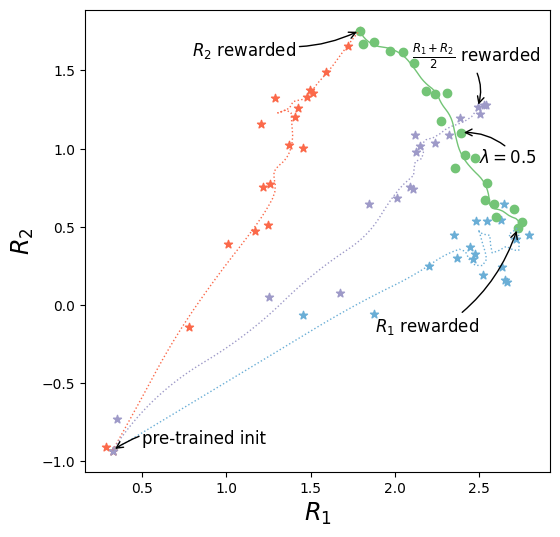

In [32]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_hfb_hfd_200], key_x="hfb", key_y="hfd", dict_annotation_to_loc={
        "pt": (0.5, -0.8), "0": (2.5, -0.2), "1": (0.8, 1.7),
        "lambda": (2.5, 1.0),
        "01": (2.1, 1.5)
        },
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_review_hfbtohfd.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_scatter_nlp(
#     modules_hfb_hfd_200[5].l,
#     keys_y=["norm|hfb", "norm|hfd", "norm|hfl", "norm|hfg"],
# )

# Backup

In [ ]:
from llamahf32 import logs_hfb_hfd_step190, logs_hfb_hfd_step10, logs_hfb_hfd_step70, logs_quality2_pos_step140, logs_hfb_hfd_step120, logs_hfb_hfd_step20, logs_hfb_hfd_step170, logs_alpaca_hfb_noref_step90, logs_quality2_hfb_step10, logs_alpaca_hfd_noref_step90, logs_hfb_hfd_noref_step90, logs_quality2_pos_step60, logs_rl_merged_lora8, logs_hfb_hfd_step170_200, logs_hfb_hfd_step170_200_fixed, logs_hfb_hfd_step190_200_fixed, logs_toxic_quality_step40, logs_toxic_quality_step90_200, logs_alpaca_toxic_quality_step90_200, logs_toxic_step90, logs_pos_step90, logs_toxic_step190, logs_toxic_hfb_step190

modules = [
    logs_hfb_hfd_noref_step90, logs_alpaca_hfb_noref_step90, logs_alpaca_hfd_noref_step90,
    logs_quality2_hfb_step10
]

modules_toxic = [logs_toxic_hfb_step190, logs_toxic_step90, logs_toxic_step190]
modules_pos = [logs_pos_step90]
modules_quality2_pos = [
    logs_alpaca_toxic_quality_step90_200, logs_toxic_quality_step90_200, logs_toxic_quality_step40,
    logs_quality2_pos_step60, logs_quality2_pos_step140
]
modules_hfb_hfd = [
    logs_hfb_hfd_step10,
    logs_rl_merged_lora8,
    logs_hfb_hfd_step20,
    logs_hfb_hfd_step70,
    logs_hfb_hfd_step120,
    logs_hfb_hfd_step170,
    logs_hfb_hfd_step190,
    logs_hfb_hfd_step170_200_fixed,
    logs_hfb_hfd_step190_200_fixed,
    logs_hfb_hfd_step170_200,
]

In [ ]:
for modules in [
    modules_quality2_pos, modules_toxic, modules_pos, modules_hfb_hfd
]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["pos0"] = module.d[key][0]["POSITIVE"]
                new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                new_d["pos1"] = module.d[key][1]["POSITIVE"]
                new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                new_d["toxic"] = module.d[key][2]["toxic"]
                new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                new_d["quality"] = module.d[key][3]["good"]
                new_d["quality1"] = module.d[key][3]["medium"]
                new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                new_d["hfl"] = module.d[key][4]["LABEL_0"]
                new_d["hfb"] = module.d[key][5]["REWARD"]
                new_d["hfd"] = module.d[key][6]["REWARD"]
                new_d["hfg"] = module.d[key][7]["LABEL_0"]
                if len(module.d[key]) >= 9:
                    new_d["toxicnew"] = module.d[key][8]["toxic"]
                module.l.append(new_d)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_hfb_hfd],
    #list_indexes = [-1],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_hfb_hfd],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_hfb_hfd)],
    connect_points=True,
    connect_endpoints=False,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_pos],
    key_x="pos0",
    key_y="pos1",
    labels=[module.label for module in modules_pos],
    loc="lower left",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_pos)],
    connect_points=True,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_toxic],
    key_x="-toxic",
    key_y="hfb",
    labels=[module.label for module in modules_toxic],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_toxic)],
    connect_points=True,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_quality2_pos],
    key_x="nontoxic",
    key_y="qualityd",
    labels=[module.label for module in modules_quality2_pos],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_quality2_pos)],
    connect_points=True,
    order=2,
)

In [ ]:
modules_summary_debug = [
    logs_tristan_cog_step40_kl005,
    logs_tristan_cog_step40,
    logs_tristan_cog_stepend,
    logs_tristan_cog_step30,
    logs_alpaca_cog,
    logs_alpaca_cog_kl005,
]
modules_summary_soups = [logs_alpaca_cogsoups_step40, logs_cogsoups_step40]

fig_dr = plot.plot_key(
    [module.l for module in modules_summary_soups],
    key_x="tristan",
    key_y="cogd",
    labels=[module.label for module in modules_summary_soups],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_summary_soups)],
    connect_points=True,
    connect_endpoints=True,
    order=2,
)

In [ ]:
keys_y = ["hfb", "hfd", "hfl", "hfg"]

fig_dr = plot.plot_basic_scatter(
    modules_hfb_hfd_200[5].l,
    key_x="lambda",
    keys_y=[y for i, y in enumerate(keys_y) if i in [2] or True],
    loc="lower right",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=['Blues', "Reds", 'Greens', 'Purples', 'Greys'],
    linestyles=['solid', 'solid', "dotted", 'dotted', 'dotted', "dotted", "dotted", "dotted"],
    order="2",
    legendtitle=f"Rewards for {modules_hfb_hfd_200[5].label}:",
    title=None
)

In [ ]:
do_save = True

# LLAMA HF

In [ ]:
from llamahf import logs_rl_alpaca_hfd_hfb, logs_rl_alpaca_hfd_hfb5, logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd

In [ ]:
modules = [
    logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_alpaca_hfd_hfb,
    logs_rl_alpaca_hfd_hfb5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd
]
for module in modules:
    module.l = []
    for key in module.d.keys():
        if True:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            new_d["hfd"] = module.d[key][6]["REWARD"]
            module.l.append(new_d)

In [ ]:

fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)

# LLAMA

In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/llama")

In [ ]:
from llama import logs_rl_quality2_hf, logs_rl_posimdb_pos, logs_rl_hfl_quality2, logs_rl_hfl_hf, logs_rl_alpaca_posimdb, logs_rl_pos_hf, logs_rl_posimdb_quality2, logs_rl_alpaca_quality2, logs_rl_alpaca_hf, logs_rl_posimdb_hf, logs_rl_pos_quality2 

In [ ]:
modules = [
    logs_rl_alpaca_hf,
    logs_rl_alpaca_posimdb,
    logs_rl_posimdb_hf,
    # logs_rl_posimdb_pos,
    logs_rl_pos_hf,
    logs_rl_pos_quality2,
    logs_rl_quality2_hf,
    logs_rl_posimdb_quality2,
    # logs_rl_hfl_hf,
    # logs_rl_hfl_quality2
    logs_rl_alpaca_quality2,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            module.l.append(new_d)

In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    list_indexes=range(4),
    key_x="hfb",
    key_y="pos1",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="lambda",
    colormaps=[
        "Reds",
        "Purples",
        "Greys",
        "Oranges",
        "Blues",
        "Yellows",
        "Greens",
        "Reds"
    ],
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)

# NEOX

In [ ]:
sys.path.append("/data/rame/logs_experiments_notebook/")
from gptneox import logs_posimdb_negimdb, logs_quality_negimdb, logs_toxic_neg, logs_rl_pos_vs_toxic, logs_rl_posimdb_vs_toxic0, logs_rl_pos_vs_quality2, logs_rl_toxic_vs_quality1, logs_rl_toxic_vs_quality2, logs_rl_posimdb_vs_toxic, logs_rl_pos_posimdb

In [ ]:
modules = [
    logs_posimdb_negimdb, logs_quality_negimdb, logs_rl_pos_vs_quality2, logs_rl_pos_posimdb,
    # logs_toxic_neg,
    # logs_rl_pos_vs_toxic,
    # logs_rl_posimdb_vs_toxic0,
    # logs_rl_toxic_vs_quality1,
    # logs_rl_toxic_vs_quality2,
    # logs_rl_posimdb_vs_toxic,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            module.l.append(new_d)

In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="posd0",
    key_y="quality",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="lambda",
    # colormaps=[
    #     "Reds",
    #     "Purples",
    #     "Oranges",
    #     "Greys",
    #     "Blues",
    #     "Yellows",
    #     "Greens",
    # ],
    linestyles=["solid" for module in modules],
    # linestyles=[ls if ls not in [] else None for ls in [
    #     "solid",
    #     "dashed",
    #     "solid",
    #     "solid",
    # ]],
    connect_points=True,
    order=2,
)

# Backup

In [ ]:
from llamastack import steps1_0406, wainitto1_0406, wa0to1_0406_step241, wa0to1_0406, wainitto0_0406, steps0_0406, multi01steps_0406, steps0_bs126_0411, steps0v2_0406

modules_stack = [
    steps0_bs126_0411, steps0_0406, steps0v2_0406, wainitto0_0406, steps1_0406, wainitto1_0406,
    wa0to1_0406_step241, wa0to1_0406, multi01steps_0406
]

fig_dr = plot.plot_key(
    [module.l for module in modules_stack],
    key_x="gpt2",
    key_y="hfb",
    # list_indexes=[2],
    labels=[module.label for module in modules_stack],
    # loc=(1.05, 0),
    loc="upper right",
    colormaps=["Purples", "Blues", "Blues", "Reds", "Reds", "Greens", "Greens", "Purples", "Greys"],
    linestyles=[
        "solid", "solid", "dashed", "solid", "dashed", "solid", "dotted", "dashdot", "dashdot"
    ],
    connect_endpoints=False,
    # order="connect",
    order="savgol_3_1_quadratic",
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_stack_gpt2tohfb.pdf", do_save=do_save)

In [ ]:
modules_assistant_nokl = [logs_assistant_d_steps, logs_assistant_b_steps, logs_assistant_bd_wa]
modules_assistant_multi = [
    logs_assistant_multikl_steps_0406, logs_assistantsteps_hfb_kl005_fmulti_normallr,
    logs_assistantsteps_hfb_kl005_fmulti, logs_assistantsteps_hfd_kl005_fmulti_normallr,
    logs_assistantsteps_hfd_kl005_fmulti
]
fig_dr = plot.plot_key(
    [module.l for module in modules_assistant_nokl],
    # list_indexes=[0,2,4,5],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_assistant_nokl],
    loc=(1.05, 0),
    colormaps=["Blues", "Reds", "Greens"],
    linestyles=["solid", "solid", "dotted"],
    connect_endpoints=False,
    order="connect",
    # order="savgol_3_1_quadratic",
)
fig_dr = plot.plot_key(
    [module.l for module in modules_assistant_multi],
    # list_indexes=[0,2,4,5],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_assistant_multi],
    loc=(1.05, 0),
    colormaps=["Greens", "Blues", "Blues", "Reds", "Reds"],
    linestyles=["dotted", "solid", "dashed", "solid", "dashed"],
    connect_endpoints=False,
    order="connect",
    # order="savgol_3_1_quadratic",
)